# Reading a raster file and print statistics

## GDAL

- first we will do something in GDAL and then in rasterio to see the differences

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline
from osgeo import gdal, osr
import sys
import struct
import numpy
import os

In [131]:
dataset = gdal.Open(os.path.join("dsm.tif"), gdal.GA_ReadOnly)
if dataset is None:
    print "Open failed.\n"
    sys.exit(1)

#
# Query and print dataset Information
#

# Dataset driver
print 'Driver: ', dataset.GetDriver().ShortName, '/', \
      dataset.GetDriver().LongName

# Raster size (rows/columns/nr of bands)
print 'Size is ', dataset.RasterXSize, 'x', dataset.RasterYSize, \
      'x', dataset.RasterCount

# Georeference
print 'Projection is ', dataset.GetProjection()

# Raster location / Pixel size / raster orientation
geotransform = dataset.GetGeoTransform()
if not geotransform is None:
    print 'Origin = (', geotransform[0], ',', geotransform[3], ')'
    print 'Pixel Size = (', geotransform[1], ',', geotransform[5], ')'
    if geotransform[2] != 0. or geotransform[4] != 0.:
        print "Oblique raster orientation."
    else:
        print "Raster parallel to coordinate axis."

Driver:  GTiff / GeoTIFF
Size is  451 x 351 x 1
Projection is  LOCAL_CS["X-Y-Z",UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( 527799.5 , 5340350.5 )
Pixel Size = ( 1.0 , -1.0 )
Raster parallel to coordinate axis.


- Fetching a raster band
- note that the first band is adressed with index 1!!

In [132]:
band = dataset.GetRasterBand(1)

print 'Band Type=', gdal.GetDataTypeName(band.DataType)

minVal = band.GetMinimum()
maxVal = band.GetMaximum()
if minVal is None or maxVal is None:
    minVal, maxVal = band.ComputeRasterMinMax(1)
print 'Min=%.3f, Max=%.3f' % (minVal, maxVal)

if band.GetOverviewCount() > 0:
    print 'Band has ', band.GetOverviewCount(), ' overviews.'

if not band.GetRasterColorTable() is None:
    print 'Band has a color table with ', \
        band.GetRasterColorTable().GetCount(), ' entries.'

nodata = band.GetNoDataValue()
print "Value indicating data voids:", nodata

Band Type= Float32
Min=258.803, Max=293.878
Value indicating data voids: 9999.0


Reading raster data in GDAL can be done several ways. We will use two:

- ReadRaster method, sometimes seen in older code, just so you know what it does
- ReadAsArray method, reads directly into numpy array

In [133]:
# Read first line (starting from upper left corner)
scanline = band.ReadRaster(
    0, 0, band.XSize, 1, band.XSize, 1, gdal.GDT_Float32)
print "ReadRaster returned: ", scanline
tuple_of_floats = struct.unpack('f' * band.XSize, scanline)
print "Converted to floats:", tuple_of_floats

ReadRaster returned:  ��CӃ�Cd��C#��C��C���C6��C3��Cn��C���C���C���C`��C��C�}�C�|�C/}�C�}�C�|�C4}�C�z�C�x�C'x�C�u�C�v�CXx�C�x�C�x�Ctw�C�w�C1w�C�w�C\x�C y�Csy�C�y�C�w�C�y�C�|�C���C��C��Cߌ�C��C���C]��C���CՎ�C���C���Cm��C:��CƎ�Cލ�C�Cԉ�CCo��Cv�C^z�CR��CZ׃C�;�C��CǂC��C<��C��CTm�C�f�C�`�CT]�C�W�C�H�C�7�C^/�C <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F�z�C�C��C�l�C���C��C�CŴ�C��C�6�CR�CQP�C��C��Cq��C��Cm*�C���C�ăCBa�C�d�C.�Cc׆C'�Cq�C{�C�C���C���Cs��C1|�C�C���C�r�C�u�CAh�CSL�COM�CoS�C�N�CvO�CO�C+N�C <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <F <FF�C�O�Cw~�C��C�ЂC܂C��Cg�C

In [134]:
# we can also read the first line using ReadAsArray directly
array = band.ReadAsArray(0, 0, band.XSize, 1)
print array.shape
print len(tuple_of_floats)
# close the dataset
dataset = None

(1, 451)
451


## Rasterio

GTiff
(451, 351, (351, 451))
Origin = ( 527799.5 , 5340350.5 )
Pixel Size = ( 1.0 , -1.0 )
LOCAL_CS["X-Y-Z",UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
(1.0, 1.0)
[9999.0]
['float32']
(1, 351, 451)
258.803 9999.0
(351, 451)


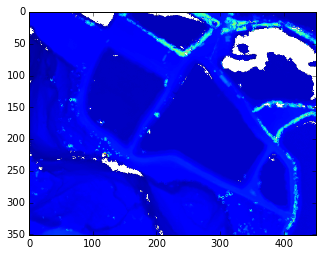

258.803 293.878
(1, 451)


In [135]:
import rasterio
with rasterio.drivers():
    with rasterio.open(os.path.join("dsm.tif")) as src:
        print(src.driver)
        print(src.width, src.height, src.shape)
        # affine property contains the geotransformation parameters
        print 'Origin = (', src.affine[2], ',', src.affine[5], ')'
        print 'Pixel Size = (', src.affine[0], ',', src.affine[4], ')'
        print(src.crs_wkt) 
        print(src.res)
        print(src.nodatavals)
        print(src.dtypes)
        # reading statistics from metadata not yet supported
        # but we can calculate them using numpy.

        # reading data
        # can also be used with band indices, defaults to reading all bands
        banddata = src.read() 
        print banddata.shape
        print banddata.min(), banddata.max()
        # default is to read the data as is 
        banddata = src.read(indexes=1, masked=True) 
        print banddata.shape
        plt.imshow(banddata)
        plt.show()
        print banddata.min(), banddata.max()
        # we can also just read a window of the data like we did above using the GDAL interface
        banddata = src.read(indexes=1, masked=True, window=((0, 1), (0, src.width)))
        print banddata.shape
        # dataset is closed because we used a context manager


# Raster data format conversion

convert from one datatype to another - gdaltranslate would do something similar
in the command line

## GDAL

In [136]:
src_filename = os.path.join("dsm.tif")
dst_filename = os.path.join("dsm.jpeg")

dname = "AAIGrid"  # ArcInfo (ESRI) ASCII Grid
driver = gdal.GetDriverByName(dname)
metadata = driver.GetMetadata()
if metadata.has_key(gdal.DCAP_CREATE) \
   and metadata[gdal.DCAP_CREATE] == 'YES':
    print 'Driver %s supports Create() method.' % dname
if metadata.has_key(gdal.DCAP_CREATECOPY) \
   and metadata[gdal.DCAP_CREATECOPY] == 'YES':
    print 'Driver %s supports CreateCopy() method.' % dname

src_ds = gdal.Open(src_filename)
dst_ds = driver.CreateCopy(dst_filename, src_ds, 0)

# Once we're done, close properly the dataset
dst_ds = None
src_ds = None


Driver AAIGrid supports CreateCopy() method.


## Rasterio

makes the copying of data easier but does currently not allow access to driver
metadata.

In [137]:
with rasterio.drivers() as drivers:

    rasterio.copy(
        src_filename,
        dst_filename,
        driver='AAIGrid')


# Dataset creation

We can create datasets from data in python, e.g. numpy arrays.

In [138]:
# create buffer containing pixel values as numpy array
raster = numpy.zeros((5, 5), dtype=numpy.uint8)
raster[1:4, 1:4] = 120
raster[2, 2] = 255
print "Pixel values:\n", raster

# Set Spatial References System
srs = osr.SpatialReference()
srs.SetUTM(33, 1)
srs.SetWellKnownGeogCS('WGS84')

dst_filename = os.path.join("pyramid.tif")
driver = gdal.GetDriverByName("GTiff")

# Create empty raster dataset with 5x5 pixels (single band) of type 1-byte
# unsigned int
dst_ds = driver.Create(dst_filename, 5, 5, 1, gdal.GDT_Byte)

# Set the geo-transformation (i.e. 6 parameters of 2D affine transformation)
dst_ds.SetGeoTransform([527800.000, 10, 0, 5340000, 0, -10])
dst_ds.SetProjection(srs.ExportToWkt())
dst_ds.GetRasterBand(1).WriteArray(raster)
# Once we're done, close properly the dataset
dst_ds = None

Pixel values:
[[  0   0   0   0   0]
 [  0 120 120 120   0]
 [  0 120 255 120   0]
 [  0 120 120 120   0]
 [  0   0   0   0   0]]


Creation of a new dataset is not that different right now. One advantage is the
context manager and that we do not need to know the gdal datatype

In [139]:
with rasterio.drivers():
    with rasterio.open(os.path.join("pyramid_rasterio.tif"), "w",
                       driver='GTiff', count=1, width=5, height=5, dtype=numpy.uint8,
                       crs=srs.ExportToWkt(),
                       transform=[527800.000, 10, 0, 5340000, 0, -10]) as dst:
        dst.write_band(1, raster)
        print dst.read(indexes=1)


[[  0   0   0   0   0]
 [  0 120 120 120   0]
 [  0 120 255 120   0]
 [  0 120 120 120   0]
 [  0   0   0   0   0]]


# Exercise

Read, inspect and plot a 10x10 pixel subset of the file *dsm_zco.tif* using either the GDAL API or rasterio.